In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
#import seaborn as sns
from datetime import datetime
#import scipy.stats as stats
#import statsmodels.api as sm
import re
from shapely.geometry import Point
import geopandas as gpd
#import folium
#from folium.plugins import MarkerCluster
#from folium.plugins import FastMarkerCluster
from ipywidgets import interact, interactive, fixed, interact_manual
import plotly.express as px
import chart_studio
import chart_studio.plotly as py


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [2]:
airbnb = pd.read_csv('../data/airbnb_df.csv')

In [3]:
airbnb.head()

,listing_id,comments_concatenated,name,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,listing_url,description,neighborhood_overview,host_since,host_listings_count,property_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights_avg_ntm,maximum_nights_avg_ntm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,zip_code,GEOID,house_price_2021-01-31,house_pct_change,rentals_2021-01-31,rental_price_pct_change,new_restaurants,available_beer,str_permits_2020,str_permits_growth,crimes,total_pop_2010,total_pop_2019,total_pop_change,total_pop_pct_change,pop_over25_2010,pop_over25_2019,pop_over25_change,pop_over25_pcg_change,total_households_2010,total_households_2019,total_households_change,total_households_pct_change,white_pct_2010,white_pct_2019,white_value_change,white_pct_change,bach_pct_2010,bach_pct_2019,bach_value_change,bach_pct_change,rent_pct_2010,rent_pct_2019,rent_value_change,renter_pct_change,median_hhi_2010,median_hhi_2019,median_hhi_value_change,median_hhi_pct_change,poverty_pct_2010,poverty_pct_2019,poverty_value_change,poverty_pct_change
0,6422,I can't say enough about how wonderful it was ...,Nashville Charm,12172,36.17315,-86.73581,40,30,674,4.69,1,267,https://www.airbnb.com/rooms/6422,30 day or more rental during COVID. Show COVID...,Historic East Nashville is home to many new an...,2009-04-03,0.0,Private room in house,2,1 private bath,2.0,3.0,"[""Hair dryer"", ""Bathtub"", ""Lock on bedroom doo...",30.0,365.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,37206.0,4.703701e+10,412476.0,38.31,NaN,NaN,1.0,2.0,114.0,114.0,1165.0,2544.0,2100.0,-444.0,-0.174528,1703.0,1639.0,-64.0,-0.037581,1140.0,926.0,-214.0,-0.187719,0.657626,0.940952,0.283327,0.430833,0.408691,0.585723,0.177032,0.433170,0.320175,0.240821,-0.079355,-0.247848,46000.0,91643.0,45643.0,0.992239,10.6,10.2,-0.4,-0.037736
1,25613,Nell and Michael made my stay pleasant and eas...,Room in Historic East Nashville Craftsman Home,95811,36.17826,-86.74162,75,2,510,3.87,1,63,https://www.airbnb.com/rooms/25613,Serve up some sweet sounds on the piano and wi...,This home is in a walkable neighborhood with i...,2010-03-18,1.0,Private room in house,2,1 private bath,1.0,1.0,"[""Hair dryer"", ""Carbon monoxide alarm"", ""Air c...",2.0,1125.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,37206.0,4.703701e+10,412476.0,38.31,NaN,NaN,3.0,12.0,101.0,101.0,1048.0,2485.0,2525.0,40.0,0.016097,1895.0,1938.0,43.0,0.022691,1234.0,1092.0,-142.0,-0.115073,0.889738,0.930297,0.040559,0.045585,0.472296,0.742002,0.269707,0.571055,0.416532,0.274725,-0.141806,-0.340446,52372.0,116800.0,64428.0,1.230199,21.6,4.1,-17.5,-0.810185
2,136015,"Very relaxing, beautiful property, and warm / ...",Apart. on the Ridge near Opryland,666322,36.19464,-86.67195,103,30,50,0.43,2,190,https://www.airbnb.com/rooms/136015,Fantastic View! Overlooks farms and is on the ...,Dead end street with great neighbors!,2011-06-05,4.0,Entire apartment,2,1 bath,1.0,1.0,"[""Fire extinguisher"", ""Wifi"", ""Dryer"", ""Washer...",30.0,1125.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,37214.0,4.703702e+10,278031.0,65.43,1581.0,22.18,9.0,112.0,48.0,48.0,4429.0,5411.0,6024.0,613.0,0.113288,4451.0,4970.0,519.0,0.116603,2566.0,2714.0,148.0,0.057677,0.781186,0.760458,-0.020728,-0.026534,0.365311,0.430986,0.065675,0.179778,0.120811,0.179071,0.058261,0.482250,53590.0,68532.0,14942.0,0.278821,3.6,6.9,3.3,0.916667
3,258817,Diana is such a gracious hostess. She has a b...,ButterflyRoom-private bath- open Jan 26,22296,36.16249,-86.58988,27,30,96,0.86,7,364,https://www.airbnb.com/rooms/258817,Morningstar House! Extended stay - 3+ months- ...,"I'm very near the Percy Priest Lake, natural ...",2009-06-19,16.0,Private room in house,2,1 private bath,1.0,2.0,"[""Hair dryer"", ""Air conditioning"", ""Smoke alar...",30.0,365.0,95.0,10.0,9.0,10.0,10.0,9.0,9.0,37076.0,4

In [4]:
# Keep only features that I will use to identify gentrification
gentrification_features = ['GEOID', 'house_pct_change', 'rental_price_pct_change', 'white_pct_change', 
                           'bach_pct_change', 'renter_pct_change', 'median_hhi_pct_change', 'poverty_pct_change']

In [5]:
gentrification_df = airbnb[gentrification_features].drop_duplicates('GEOID')

In [6]:
gentrification_df = gentrification_df[gentrification_df['GEOID'].notna()]

In [7]:
gentrification_df.head()

,GEOID,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
0,4.703701e+10,38.31,NaN,0.430833,0.433170,-0.247848,0.992239,-0.037736
1,4.703701e+10,38.31,NaN,0.045585,0.571055,-0.340446,1.230199,-0.810185
2,4.703702e+10,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667
3,4.703702e+10,51.53,NaN,-0.176354,-0.037855,-0.028681,0.122428,1.088235
7,4.703702e+10,38.31,NaN,0.049556,0.387603,0.112385,0.720376,-0.228758


In [8]:
gentrification_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 4825
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   GEOID                    150 non-null    float64
 1   house_pct_change         149 non-null    float64
 2   rental_price_pct_change  87 non-null     float64
 3   white_pct_change         149 non-null    float64
 4   bach_pct_change          149 non-null    float64
 5   renter_pct_change        148 non-null    float64
 6   median_hhi_pct_change    147 non-null    float64
 7   poverty_pct_change       148 non-null    float64
dtypes: float64(8)
memory usage: 10.5 KB


In [9]:
gentrification_df.shape

(150, 8)

In [10]:
# Create list of features that need NaNs filled by medians
medians = ['house_pct_change', 'rental_price_pct_change', 'white_pct_change', 'bach_pct_change', 'renter_pct_change', 
           'median_hhi_pct_change', 'poverty_pct_change']

In [11]:
gentrification_df[medians] = gentrification_df[medians].fillna(gentrification_df.median())

In [12]:
gentrification_df.head()

,GEOID,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
0,4.703701e+10,38.31,18.35,0.430833,0.433170,-0.247848,0.992239,-0.037736
1,4.703701e+10,38.31,18.35,0.045585,0.571055,-0.340446,1.230199,-0.810185
2,4.703702e+10,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667
3,4.703702e+10,51.53,18.35,-0.176354,-0.037855,-0.028681,0.122428,1.088235
7,4.703702e+10,38.31,18.35,0.049556,0.387603,0.112385,0.720376,-0.228758


In [13]:
gentrification_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 4825
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   GEOID                    150 non-null    float64
 1   house_pct_change         150 non-null    float64
 2   rental_price_pct_change  150 non-null    float64
 3   white_pct_change         150 non-null    float64
 4   bach_pct_change          150 non-null    float64
 5   renter_pct_change        150 non-null    float64
 6   median_hhi_pct_change    150 non-null    float64
 7   poverty_pct_change       150 non-null    float64
dtypes: float64(8)
memory usage: 10.5 KB


In [14]:
gentrification_df.describe()

,GEOID,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
count,1.500000e+02,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,4.703702e+10,53.128067,18.353067,0.774029,0.444372,0.210394,0.413937,inf
std,7.880766e+04,13.602770,4.888480,5.382851,0.742882,0.515318,0.386433,NaN
min,4.703701e+10,31.110000,7.730000,-0.413595,-0.377566,-0.369817,-0.180354,-0.863874
25%,4.703701e+10,40.190000,18.350000,-0.091308,0.031430,-0.039293,0.163609,-0.183005
50%,4.703702e+10,51.350000,18.350000,-0.002333,0.184014,0.080751,0.341001,0.224314
75%,4.703702e+10,65.417500,18.350000,0.151780,0.588447,0.251190,0.581724,1.078472
max,4.703798e+10,74.310000,29.300000,64.071146,4.396047,2.792779,2.454128,inf


In [15]:
gentrification_df['GEOID'] = gentrification_df['GEOID'].astype(int).astype(str)

In [16]:
gentrification_df = gentrification_df.set_index('GEOID')

In [17]:
gentrification_df.head()

,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
GEOID,,,,,,,
47037012200,38.31,18.35,0.430833,0.433170,-0.247848,0.992239,-0.037736
47037012100,38.31,18.35,0.045585,0.571055,-0.340446,1.230199,-0.810185
47037015300,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667
47037015610,51.53,18.35,-0.176354,-0.037855,-0.028681,0.122428,1.088235
47037019200,38.31,18.35,0.049556,0.387603,0.112385,0.720376,-0.228758


In [18]:
gentrification_bools = gentrification_df.copy()

In [19]:
gentrification_bools['house_pct_change_bool'] = np.where(
    gentrification_bools['house_pct_change'] > gentrification_bools['house_pct_change'].quantile(0.80), True, False)

gentrification_bools['rental_price_pct_change_bool'] = np.where(
    gentrification_bools['rental_price_pct_change'] > gentrification_bools['rental_price_pct_change'].quantile(0.80), True, False)

gentrification_bools['white_pct_change_bool'] = np.where(
    gentrification_bools['white_pct_change'] > gentrification_bools['white_pct_change'].quantile(0.80), True, False)

gentrification_bools['bach_pct_change_bool'] = np.where(
    gentrification_bools['bach_pct_change'] > gentrification_bools['bach_pct_change'].quantile(0.80), True, False)

gentrification_bools['renter_pct_change_bool'] = np.where(
    gentrification_bools['renter_pct_change'] < gentrification_bools['renter_pct_change'].quantile(0.20), True, False)

gentrification_bools['median_hhi_pct_change_bool'] = np.where(
    gentrification_bools['median_hhi_pct_change'] > gentrification_bools['median_hhi_pct_change'].quantile(0.80), True, False)

gentrification_bools['poverty_pct_change_bool'] = np.where(
    gentrification_bools['poverty_pct_change'] < gentrification_bools['poverty_pct_change'].quantile(0.20), True, False)

In [20]:
gentrification_bools.head()

,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change,house_pct_change_bool,rental_price_pct_change_bool,white_pct_change_bool,bach_pct_change_bool,renter_pct_change_bool,median_hhi_pct_change_bool,poverty_pct_change_bool
GEOID,,,,,,,,,,,,,,
47037012200,38.31,18.35,0.430833,0.433170,-0.247848,0.992239,-0.037736,False,False,True,False,True,True,False
47037012100,38.31,18.35,0.045585,0.571055,-0.340446,1.230199,-0.810185,False,False,False,False,True,True,True
47037015300,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667,False,False,False,False,False,False,False
47037015610,51.53,18.35,-0.176354,-0.037855,-0.028681,0.122428,1.088235,False,False,False,False,False,False,False
47037019200,38.31,18.35,0.049556,0.387603,0.112385,0.720376,-0.228758,False,False,False,False,False,True,False


In [21]:
gentrification_bools.columns

Index(['house_pct_change', 'rental_price_pct_change', 'white_pct_change', 'bach_pct_change', 'renter_pct_change', 'median_hhi_pct_change', 'poverty_pct_change', 'house_pct_change_bool', 'rental_price_pct_change_bool', 'white_pct_change_bool', 'bach_pct_change_bool', 'renter_pct_change_bool', 'median_hhi_pct_change_bool', 'poverty_pct_change_bool'], dtype='object')

In [22]:
gentrification_counts = gentrification_bools[['house_pct_change_bool', 'rental_price_pct_change_bool', 
                                           'white_pct_change_bool', 'bach_pct_change_bool', 
                                           'renter_pct_change_bool', 'median_hhi_pct_change_bool', 
                                           'poverty_pct_change_bool']]

In [23]:
gentrification_counts['total'] = gentrification_counts.sum(axis=1)

<ipython-input-23-4106c436465a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gentrification_counts['total'] = gentrification_counts.sum(axis=1)


## Visualize census tracts that fit each feature's highest percentiles

In [24]:
tracts = gpd.read_file('../data/cb_2018_47_tract_500k.shp')

In [25]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,47,093,001900,1400000US47093001900,47093001900,19,CT,2203514,13116,"POLYGON ((-83.90062 35.99202, -83.88800 36.000..."
1,47,093,003902,1400000US47093003902,47093003902,39.02,CT,3451146,0,"POLYGON ((-83.98563 36.00119, -83.98152 36.004..."
2,47,093,004404,1400000US47093004404,47093004404,44.04,CT,5964584,11451,"POLYGON ((-84.03695 35.93007, -84.02293 35.933..."
3,47,093,005708,1400000US47093005708,47093005708,57.08,CT,3557676,38601,"POLYGON ((-84.11800 35.86332, -84.11387 35.866..."
4,47,093,006103,1400000US47093006103,47093006103,61.03,CT,6437142,0,"POLYGON ((-84.07012 36.02888, -84.06820 36.031..."


In [26]:
tracts['FIPS'] = tracts.STATEFP + tracts.COUNTYFP

In [27]:
tracts = tracts[tracts['FIPS']=='47037'][['GEOID', 'geometry']]

In [28]:
#1: Total Claims vs ODs, colored by percent of claims by selected opioid (all graphs use same color choice)
# Problem - Does not show significant results. 

@interact(feature = gentrification_counts.columns.to_list()[-9:-1])

def gentrification_map(feature) :
    tracts_visual = tracts.copy()
    
    visual_tracts = gentrification_counts[gentrification_counts[feature]==True].index.to_list()
    
    tracts_visual['visual'] = np.where(tracts.GEOID.isin(visual_tracts), True, False)
    
   # leg_kwds = {'title': 'Changing Neighborhoods', 'loc': 'upper left', 
   #         'bbox_to_anchor': (1, 1.03), 'ncol': 1}

    tracts_visual.plot(column = 'visual',
            figsize=(10, 10),
            edgecolor = 'black',
            cmap = 'Set2');

interactive(children=(Dropdown(description='feature', options=('house_pct_change_bool', 'rental_price_pct_chan…

In [29]:
gentrification_counts.head()

,house_pct_change_bool,rental_price_pct_change_bool,white_pct_change_bool,bach_pct_change_bool,renter_pct_change_bool,median_hhi_pct_change_bool,poverty_pct_change_bool,total
GEOID,,,,,,,,
47037012200,False,False,True,False,True,True,False,3
47037012100,False,False,False,False,True,True,True,3
47037015300,False,False,False,False,False,False,False,0
47037015610,False,False,False,False,False,False,False,0
47037019200,False,False,False,False,False,True,False,1


In [30]:
tracts_booleans = tracts.merge(gentrification_counts.reset_index()[['GEOID', 'total']], on='GEOID', how='left')

In [31]:
tracts_booleans['total'] = tracts_booleans['total'].fillna(0)

In [32]:
tracts_booleans.head()

,GEOID,geometry,total
0,47037015625,"POLYGON ((-86.65754 36.11937, -86.65558 36.122...",0.0
1,47037016000,"POLYGON ((-86.77265 36.14987, -86.76948 36.151...",4.0
2,47037017300,"POLYGON ((-86.75091 36.12039, -86.75051 36.121...",3.0
3,47037018409,"POLYGON ((-86.98225 36.07529, -86.98171 36.075...",0.0
4,47037019106,"POLYGON ((-86.74414 36.04342, -86.74375 36.047...",0.0


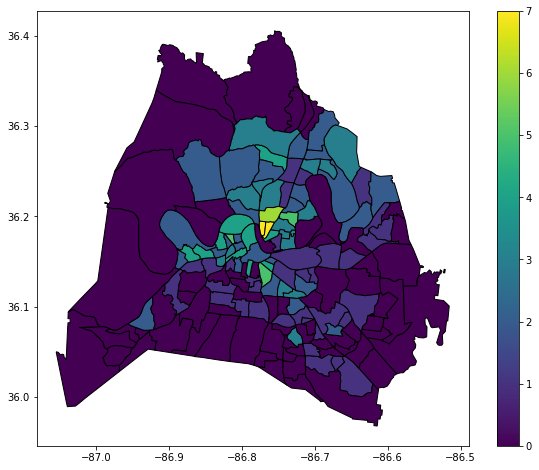

In [33]:
tracts_booleans.plot(column = 'total',
            figsize=(10, 8),
            legend=True,
            edgecolor = 'black');

## Visualize each tract by percentile

In [34]:
gentrification_df.head()

,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
GEOID,,,,,,,
47037012200,38.31,18.35,0.430833,0.433170,-0.247848,0.992239,-0.037736
47037012100,38.31,18.35,0.045585,0.571055,-0.340446,1.230199,-0.810185
47037015300,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667
47037015610,51.53,18.35,-0.176354,-0.037855,-0.028681,0.122428,1.088235
47037019200,38.31,18.35,0.049556,0.387603,0.112385,0.720376,-0.228758


In [35]:
gentrification_df.columns

Index(['house_pct_change', 'rental_price_pct_change', 'white_pct_change', 'bach_pct_change', 'renter_pct_change', 'median_hhi_pct_change', 'poverty_pct_change'], dtype='object')

In [36]:
gentrification_percents = gentrification_df[['house_pct_change', 'rental_price_pct_change', 'white_pct_change', 
                                             'bach_pct_change', 'renter_pct_change', 'median_hhi_pct_change', 
                                             'poverty_pct_change']]

In [37]:
gentrification_percents.head(1)

,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
GEOID,,,,,,,
47037012200,38.31,18.35,0.430833,0.43317,-0.247848,0.992239,-0.037736


In [38]:
#1: Total Claims vs ODs, colored by percent of claims by selected opioid (all graphs use same color choice)
# Problem - Does not show significant results. 

@interact(feature = gentrification_percents.columns.to_list())

def gentrification_map(feature) :
    percents_map = tracts.merge(gentrification_percents.reset_index()[['GEOID', feature]], on='GEOID', how='left')
    percents_map[feature] = percents_map[feature].fillna(percents_map[feature].median())
    
    test_map = px.choropleth(percents_map, 
                        geojson=percents_map.geometry,
                        locations=percents_map.index, 
                        color=feature,
                        color_continuous_scale="Viridis"#,
                        #range_color=(0, 12),
                        #labels={'unemp':'unemployment rate'}
                        )
    test_map.update_geos(fitbounds="locations", visible=False)
    
    test_map.show()

    #test_map.write_html("/Users/mattparker/Documents/nss_projects/airbnb-sentiments/notebooks/test_map.html")
    #py.plot(test_map, filename = 'test_map', auto_open=True)

interactive(children=(Dropdown(description='feature', options=('house_pct_change', 'rental_price_pct_change', …

## Determine Gentrification by Ranking

In [39]:
gentrification_df.head()

,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
GEOID,,,,,,,
47037012200,38.31,18.35,0.430833,0.433170,-0.247848,0.992239,-0.037736
47037012100,38.31,18.35,0.045585,0.571055,-0.340446,1.230199,-0.810185
47037015300,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667
47037015610,51.53,18.35,-0.176354,-0.037855,-0.028681,0.122428,1.088235
47037019200,38.31,18.35,0.049556,0.387603,0.112385,0.720376,-0.228758


In [40]:
gentrification_ranks = gentrification_df.copy()

In [41]:
gentrification_ranks['house_pct_change_rank'] = gentrification_ranks['house_pct_change'].rank(ascending=True)
gentrification_ranks['rental_price_pct_change_rank'] = gentrification_ranks['rental_price_pct_change'].rank(ascending=True)
gentrification_ranks['white_pct_change_rank'] = gentrification_ranks['white_pct_change'].rank(ascending=True)
gentrification_ranks['bach_pct_change_rank'] = gentrification_ranks['bach_pct_change'].rank(ascending=True)
gentrification_ranks['renter_pct_change_rank'] = gentrification_ranks['renter_pct_change'].rank(ascending=False)
gentrification_ranks['median_hhi_pct_change_bool'] = gentrification_ranks['median_hhi_pct_change'].rank(ascending=True)
gentrification_ranks['poverty_pct_change_bool'] = gentrification_ranks['poverty_pct_change'].rank(ascending=False)

In [42]:
gentrification_ranks.head()

,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change,house_pct_change_rank,rental_price_pct_change_rank,white_pct_change_rank,bach_pct_change_rank,renter_pct_change_rank,median_hhi_pct_change_bool,poverty_pct_change_bool
GEOID,,,,,,,,,,,,,,
47037012200,38.31,18.35,0.430833,0.433170,-0.247848,0.992239,-0.037736,29.5,75.5,131.0,104.0,143.0,139.0,94.0
47037012100,38.31,18.35,0.045585,0.571055,-0.340446,1.230199,-0.810185,29.5,75.5,89.0,112.0,149.0,144.0,149.0
47037015300,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667,116.5,118.5,58.0,74.0,19.0,67.0,44.0
47037015610,51.53,18.35,-0.176354,-0.037855,-0.028681,0.122428,1.088235,82.5,75.5,16.0,23.0,110.0,29.0,38.0
47037019200,38.31,18.35,0.049556,0.387603,0.112385,0.720376,-0.228758,29.5,75.5,90.0,99.0,64.0,126.0,115.0


In [43]:
gentrification_ranks.columns

Index(['house_pct_change', 'rental_price_pct_change', 'white_pct_change', 'bach_pct_change', 'renter_pct_change', 'median_hhi_pct_change', 'poverty_pct_change', 'house_pct_change_rank', 'rental_price_pct_change_rank', 'white_pct_change_rank', 'bach_pct_change_rank', 'renter_pct_change_rank', 'median_hhi_pct_change_bool', 'poverty_pct_change_bool'], dtype='object')

In [44]:
gentrification_rank_counts = gentrification_ranks[['house_pct_change_rank', 'rental_price_pct_change_rank', 
                                                   'white_pct_change_rank', 'bach_pct_change_rank', 
                                                   'renter_pct_change_rank', 'median_hhi_pct_change_bool', 
                                                   'poverty_pct_change_bool']]

In [45]:
gentrification_rank_counts['total'] = gentrification_rank_counts.sum(axis=1)

<ipython-input-45-4613bd0d18de>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
gentrification_rank_counts.sort_values('total', ascending=False).head(20)

,house_pct_change_rank,rental_price_pct_change_rank,white_pct_change_rank,bach_pct_change_rank,renter_pct_change_rank,median_hhi_pct_change_bool,poverty_pct_change_bool,total
GEOID,,,,,,,,
47037012600,142.5,145.5,139.0,148.0,148.0,147.0,142.0,1012.0
47037011800,142.5,145.5,141.0,135.0,147.0,146.0,138.0,995.0
47037011300,142.5,145.5,135.0,139.0,114.0,138.0,123.0,937.0
47037019400,132.0,75.5,138.0,133.0,84.0,150.0,109.0,821.5
47037013300,47.0,128.0,118.0,143.0,140.0,137.0,99.0,812.0
47037013800,132.0,75.5,144.0,136.0,30.0,145.0,144.0,806.5
47037013700,132.0,75.5,142.0,141.0,92.0,80.0,134.0,796.5
47037013202,47.0,128.0,82.0,150.0,117.0,122.0,147.0,793.0
47037011100,57.5,135.5,119.0,115.0,129.0,119.0,104.0,779.0


In [47]:
tracts_rankings = tracts.merge(gentrification_rank_counts.reset_index()[['GEOID', 'total']], on='GEOID', how='left')

In [48]:
tracts_rankings['total'] = tracts_rankings['total'].fillna(0)

In [49]:
tracts_rankings.head()

,GEOID,geometry,total
0,47037015625,"POLYGON ((-86.65754 36.11937, -86.65558 36.122...",442.0
1,47037016000,"POLYGON ((-86.77265 36.14987, -86.76948 36.151...",772.0
2,47037017300,"POLYGON ((-86.75091 36.12039, -86.75051 36.121...",755.0
3,47037018409,"POLYGON ((-86.98225 36.07529, -86.98171 36.075...",0.0
4,47037019106,"POLYGON ((-86.74414 36.04342, -86.74375 36.047...",341.5


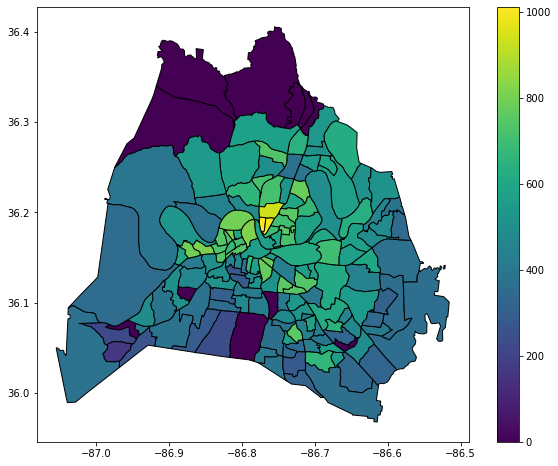

In [50]:
tracts_rankings.plot(column = 'total',
            figsize=(10, 8),
            legend=True,
            edgecolor = 'black');

In [51]:
@interact(num = range(5, 26))

def gentrification_ranking_map(num) :
    
    changing_tracts_rankings = tracts_rankings.sort_values('total', ascending=False)['GEOID'].head(num).to_list()
    tracts_rankings_vis = tracts_rankings.copy()
    tracts_rankings_vis['gentrifying'] = np.where(tracts_rankings_vis.GEOID.isin(changing_tracts_rankings), True, False)
    
    fig = px.choropleth(tracts_rankings_vis, 
                        geojson=tracts_rankings_vis.geometry,
                        locations=tracts_rankings_vis.index, 
                        color='gentrifying',
                        color_continuous_scale="Viridis"#,
                        #range_color=(0, 12),
                        #labels={'unemp':'unemployment rate'}
                        )
    fig.update_geos(fitbounds="locations", visible=False)
    
    fig.show()

interactive(children=(Dropdown(description='num', options=(5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …

In [52]:
tracts_rankings.head()

,GEOID,geometry,total
0,47037015625,"POLYGON ((-86.65754 36.11937, -86.65558 36.122...",442.0
1,47037016000,"POLYGON ((-86.77265 36.14987, -86.76948 36.151...",772.0
2,47037017300,"POLYGON ((-86.75091 36.12039, -86.75051 36.121...",755.0
3,47037018409,"POLYGON ((-86.98225 36.07529, -86.98171 36.075...",0.0
4,47037019106,"POLYGON ((-86.74414 36.04342, -86.74375 36.047...",341.5


In [106]:
changing_tracts_top = tracts_rankings.sort_values('total', ascending=False)['GEOID'].head(20).to_list()
changing_tracts_top

['47037012600',
 '47037011800',
 '47037011300',
 '47037019400',
 '47037013300',
 '47037013800',
 '47037013700',
 '47037013202',
 '47037011100',
 '47037016000',
 '47037016100',
 '47037011400',
 '47037017300',
 '47037018904',
 '47037012100',
 '47037017401',
 '47037014400',
 '47037013602',
 '47037013500',
 '47037015802']

In [107]:
tracts_rankings_final = tracts_rankings.copy()

In [108]:
tracts_rankings_final['gentrifying'] = np.where(tracts_rankings_final.GEOID.isin(changing_tracts_top), True, False)

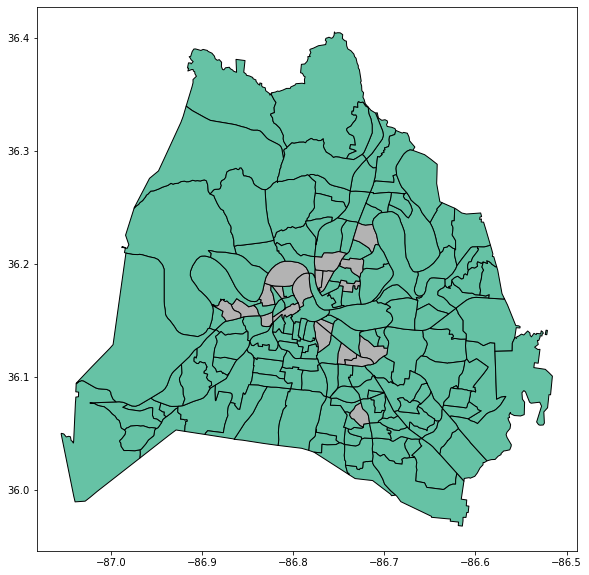

In [109]:
leg_kwds = {'title': 'Changing Neighborhoods', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 1}

tracts_rankings_final.plot(column = 'gentrifying',
            figsize=(10, 10),
            edgecolor = 'black',
            cmap = 'Set2');

## Look over full dataset with Added Boolean Column

In [110]:
airbnb['gentrifying'] = np.where(airbnb.GEOID.isin(changing_tracts_top), True, False)

In [111]:
airbnb.head()

,listing_id,comments_concatenated,name,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,listing_url,description,neighborhood_overview,host_since,host_listings_count,property_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights_avg_ntm,maximum_nights_avg_ntm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,zip_code,GEOID,house_price_2021-01-31,house_pct_change,rentals_2021-01-31,rental_price_pct_change,new_restaurants,available_beer,str_permits_2020,str_permits_growth,crimes,total_pop_2010,total_pop_2019,total_pop_change,total_pop_pct_change,pop_over25_2010,pop_over25_2019,pop_over25_change,pop_over25_pcg_change,total_households_2010,total_households_2019,total_households_change,total_households_pct_change,white_pct_2010,white_pct_2019,white_value_change,white_pct_change,bach_pct_2010,bach_pct_2019,bach_value_change,bach_pct_change,rent_pct_2010,rent_pct_2019,rent_value_change,renter_pct_change,median_hhi_2010,median_hhi_2019,median_hhi_value_change,median_hhi_pct_change,poverty_pct_2010,poverty_pct_2019,poverty_value_change,poverty_pct_change,gentrifying
0,6422,I can't say enough about how wonderful it was ...,Nashville Charm,12172,36.17315,-86.73581,40,30,674,4.69,1,267,https://www.airbnb.com/rooms/6422,30 day or more rental during COVID. Show COVID...,Historic East Nashville is home to many new an...,2009-04-03,0.0,Private room in house,2,1 private bath,2.0,3.0,"[""Hair dryer"", ""Bathtub"", ""Lock on bedroom doo...",30.0,365.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,37206.0,4.703701e+10,412476.0,38.31,NaN,NaN,1.0,2.0,114.0,114.0,1165.0,2544.0,2100.0,-444.0,-0.174528,1703.0,1639.0,-64.0,-0.037581,1140.0,926.0,-214.0,-0.187719,0.657626,0.940952,0.283327,0.430833,0.408691,0.585723,0.177032,0.433170,0.320175,0.240821,-0.079355,-0.247848,46000.0,91643.0,45643.0,0.992239,10.6,10.2,-0.4,-0.037736,False
1,25613,Nell and Michael made my stay pleasant and eas...,Room in Historic East Nashville Craftsman Home,95811,36.17826,-86.74162,75,2,510,3.87,1,63,https://www.airbnb.com/rooms/25613,Serve up some sweet sounds on the piano and wi...,This home is in a walkable neighborhood with i...,2010-03-18,1.0,Private room in house,2,1 private bath,1.0,1.0,"[""Hair dryer"", ""Carbon monoxide alarm"", ""Air c...",2.0,1125.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,37206.0,4.703701e+10,412476.0,38.31,NaN,NaN,3.0,12.0,101.0,101.0,1048.0,2485.0,2525.0,40.0,0.016097,1895.0,1938.0,43.0,0.022691,1234.0,1092.0,-142.0,-0.115073,0.889738,0.930297,0.040559,0.045585,0.472296,0.742002,0.269707,0.571055,0.416532,0.274725,-0.141806,-0.340446,52372.0,116800.0,64428.0,1.230199,21.6,4.1,-17.5,-0.810185,True
2,136015,"Very relaxing, beautiful property, and warm / ...",Apart. on the Ridge near Opryland,666322,36.19464,-86.67195,103,30,50,0.43,2,190,https://www.airbnb.com/rooms/136015,Fantastic View! Overlooks farms and is on the ...,Dead end street with great neighbors!,2011-06-05,4.0,Entire apartment,2,1 bath,1.0,1.0,"[""Fire extinguisher"", ""Wifi"", ""Dryer"", ""Washer...",30.0,1125.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,37214.0,4.703702e+10,278031.0,65.43,1581.0,22.18,9.0,112.0,48.0,48.0,4429.0,5411.0,6024.0,613.0,0.113288,4451.0,4970.0,519.0,0.116603,2566.0,2714.0,148.0,0.057677,0.781186,0.760458,-0.020728,-0.026534,0.365311,0.430986,0.065675,0.179778,0.120811,0.179071,0.058261,0.482250,53590.0,68532.0,14942.0,0.278821,3.6,6.9,3.3,0.916667,False
3,258817,Diana is such a gracious hostess. She has a b...,ButterflyRoom-private bath- open Jan 26,22296,36.16249,-86.58988,27,30,96,0.86,7,364,https://www.airbnb.com/rooms/258817,Morningstar House! Extended stay - 3+ months- ...,"I'm very near the Percy Priest Lake, natural ...",2009-06-19,16.0,Private room in house,2,1 private bath,1.0,2.0,"[""Hair dryer"", ""Air conditioning"", ""Smoke alar...",30.0,365.0,95.0,10.0,9.

In [112]:
#About 25% of AirBNBs are in gentrifying neighborhoods
airbnb.groupby('gentrifying').count()['listing_id']

gentrifying
False    3935
True     1270
Name: listing_id, dtype: int64

In [113]:
#About 12% of population lives in gentrifying neighborhoods
airbnb.drop_duplicates('GEOID').groupby('gentrifying').sum()['total_pop_2019']

gentrifying
False    586710.0
True      68009.0
Name: total_pop_2019, dtype: float64

In [119]:
airbnb.groupby('gentrifying').median()

,listing_id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_listings_count,accommodates,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,zip_code,GEOID,house_price_2021-01-31,house_pct_change,rentals_2021-01-31,rental_price_pct_change,new_restaurants,available_beer,str_permits_2020,str_permits_growth,crimes,total_pop_2010,total_pop_2019,total_pop_change,total_pop_pct_change,pop_over25_2010,pop_over25_2019,pop_over25_change,pop_over25_pcg_change,total_households_2010,total_households_2019,total_households_change,total_households_pct_change,white_pct_2010,white_pct_2019,white_value_change,white_pct_change,bach_pct_2010,bach_pct_2019,bach_value_change,bach_pct_change,rent_pct_2010,rent_pct_2019,rent_value_change,renter_pct_change,median_hhi_2010,median_hhi_2019,median_hhi_value_change,median_hhi_pct_change,poverty_pct_2010,poverty_pct_2019,poverty_value_change,poverty_pct_change
gentrifying,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,32216334,80557350,36.154580,-86.776500,133,2,30,1.60,3,179,3.0,5,2.0,2.0,2.0,1125.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,37206.0,4.703702e+10,412476.0,38.31,1682.0,18.35,7.0,10.0,120.0,120.0,2699.0,3488.0,4068.0,561.0,0.126761,2445.0,2783.0,440.0,0.164536,1512.0,1737.0,130.0,0.090075,0.587486,0.750670,0.055821,0.124566,0.365311,0.513834,0.124592,0.433170,0.548923,0.550467,0.056484,0.112385,42468.0,60710.0,21820.0,0.586988,18.5,16.9,-0.20,-0.024096
True,29984947,65712006,36.177615,-86.771785,150,2,34,1.56,2,182,2.0,7,3.0,3.0,2.0,1125.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,37208.0,4.703701e+10,351685.0,71.28,1634.0,29.30,7.0,12.0,90.0,90.0,4056.0,3114.0,3997.0,404.0,0.091701,2271.0,3238.0,677.0,0.371581,1590.0,1829.5,267.0,0.165798,0.304110,0.547935,0.208724,0.665067,0.173317,0.398536,0.208381,1.158315,0.620755,0.490632,-0.019022,-0.045223,23533.0,50857.0,29197.0,1.217025,29.0,20.5,-8.55,-0.302780


In [118]:
#airbnb.to_csv('../data/airbnb_gentrification.csv', index=False)